# Running deep learning models with BioEngine

This tutorial will show you how to run image analysis models at https://bioimage.io using the BioEngine server.

We will show you load an image, reshape it according to the spec of each model (named `RDF`, which contains meta information about models hosted at https://bioimage.io), and send the image (as numpy array) to the BioEngine server to run the specified models.

All the models we show are abailable at https://bioimage.io/# and you can adapt this tutorial for other models in the model zoo.

Note: Please be aware that the data will be sent to a remote server (https://ai.imjoy.io/triton) running by the AI4Life team, the service is for evaluation purpose only and it is subject to change without notice. We provide an on-prem deployment solution on HPC and Kubenates cluster, please see the deployment guideline here: https://bioimage-io.github.io/bioengine/#/bioengine-hpc-worker. If you are using your own instance, please change the server url (`https://ai.imjoy.io`) and triton service id (`triton-client`) accordingly in this notebook.

In [4]:
try:
    # For pyodide in the browser
    import micropip
    await micropip.install(['hypha-rpc', 'kaibu-utils', 'pyodide-http', 'requests'])
    
    # 2. Patch requests
    import pyodide_http
    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess
    subprocess.call(['pip', 'install', 'hypha-rpc', 'kaibu-utils'])

import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
#from pyotritonclient import execute
from imjoy_rpc.hypha import connect_to_server
from kaibu_utils import fetch_image




In [9]:
# Server URL: For this workshop we will use the ai.imjoy.io server
SERVER_URL = "https://ai.imjoy.io"

# Running UNet membrane segmentation model via the BioEngine

## Download an example image

example image downloaded:  (512, 512)


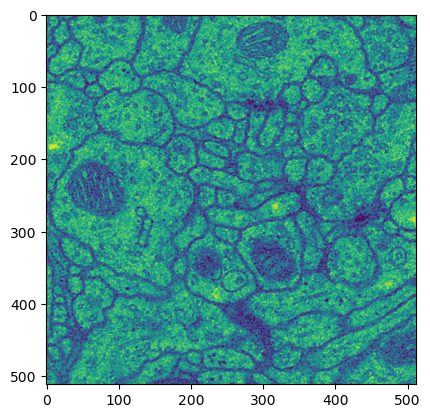

In [10]:
image = await fetch_image('https://zenodo.org/api/records/5906839/files/sample_input_0.tif/content')
image = image.astype('float32')
print("example image downloaded: ", image.shape)
plt.imshow(image)
plt.show()

## Connect to the server

In [11]:
server = await connect_to_server(
        {"server_url": SERVER_URL, "method_timeout": 3000}
    )
triton = await server.get_service("triton-client")

## View the RDF

This helps to verify the expected input format and other model details

In [7]:
ret = await triton.execute(inputs=[{'inputs': None, "model_id": "creative-panda", 'return_rdf':True}],
                           model_name="bioengine-model-runner",
                           serialization="imjoy",
                          )
print(ret['result']['rdf'])

{'inputs': [{'name': 'input0', 'axes': 'bxyc', 'shape': [1, 512, 512, 1], 'data_range': [0.0, 255.0], 'data_type': 'uint8', 'preprocessing': [{'name': 'scale_range', 'kwargs': {'axes': 'xyc', 'max_percentile': 99.8, 'min_percentile': 1, 'mode': 'per_sample'}}]}], 'timestamp': '2021-12-09T15:03:20.680270', 'tags': ['zerocostdl4mic', 'deepimagej', 'segmentation', 'electron-microscopy', 'unet', 'isbi2012-challenge', 'neurons', 'brain', 'boundary-segmentation', '2d'], 'config': {'_conceptdoi': '10.5281/zenodo.5817052', '_doi': '10.5281/zenodo.5850574', 'bioimageio': {'created': '2022-01-27 14:00:17.489637', 'doi': '10.5281/zenodo.5906839', 'nickname': 'creative-panda', 'nickname_icon': '🐼', 'owners': [271523], 'status': 'accepted', 'version_id': '5906839', 'version_name': 'revision 1'}, 'deepimagej': {'allow_tiling': True, 'model_keys': None, 'prediction': {'postprocess': [{'kwargs': 'binarize.ijm', 'spec': 'ij.IJ::runMacroFile'}], 'preprocess': [{'kwargs': 'per_sample_scale_range.ijm', 's

## Make prediction with the BioEngine

In [8]:
ret = await triton.execute(inputs=[{"inputs":[[image[...,None]]], "model_id": "creative-panda"}],
                           model_name="bioengine-model-runner",
                           serialization="imjoy",
                          )
result = ret["result"]
mask = result['outputs'][0]
print('prediction: ', mask.shape)

prediction:  (1, 512, 512, 1)


## Display the segmentation result

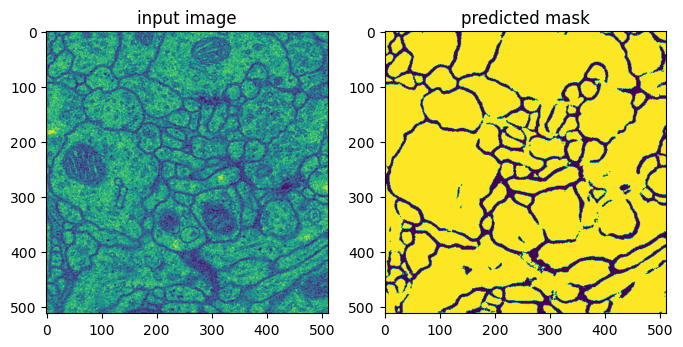

In [9]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image.astype('uint8'))
ax1.set_title('input image')
ax2.imshow(mask[0])
ax2.set_title('predicted mask')
plt.show()

# Running Stardist nuclei segmentation via the BioEngine

prediction:  (1, 512, 512, 33)
Note: use the stardist library to properly post-process this output! https://github.com/stardist/stardist


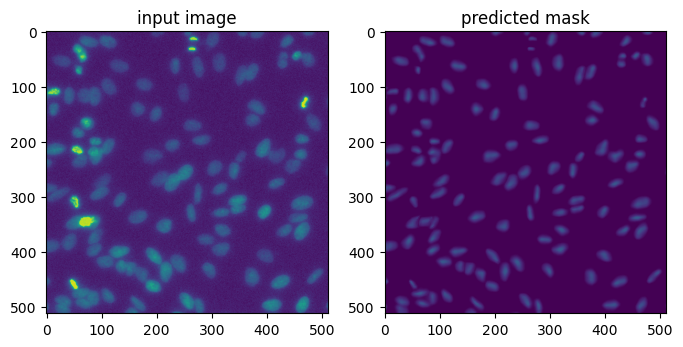

In [10]:
# obtain the model config
image = await fetch_image('https://raw.githubusercontent.com/stardist/stardist/3451a4f9e7b6dcef91b09635cc8fa78939fb0d29/stardist/data/images/img2d.tif', grayscale=True)
image = image.astype('uint16')
param = {'diameter': 30}

# run inference
ret = await triton.execute(inputs=[{
                               "inputs":[[image[...,None]]], 
                               "model_id": "fearless-crab"}], 
                           model_name="bioengine-model-runner",
                           serialization="imjoy",
                          )
result = ret["result"]
mask = result['outputs'][0]
print('prediction: ', mask.shape)
print('Note: use the stardist library to properly post-process this output! https://github.com/stardist/stardist')

# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image)
ax1.set_title('input image')
ax2.imshow(mask[0, :, :, 0])
ax2.set_title('predicted mask')
plt.show()

** Note: The above model doesn't run the stardist post-processing, so you will get many output channels as output from the U-Net model.

## Trying more models in BioImage.IO

Feel free to find more models at https://bioimage.io/, if you want to run a model, please do the following as shown above:
 - Copy the animal nickname id in the model card
 - Print the RDF information so you know what's the expected input shape
 - Load your image, and make sure you reshape or resize it according to the expected input shape using numpy or scikit-image etc.
 - Run the model via `execute`, by passing the model id, image
 - Get the result, extract the image for display according to the output shape according to the RDF.


## Hosting your own BioEngine

While the above demos uses our public free BioEngine server, you can also launch your own bioengine server on a GPU workstation or HPC, and connect to your own BioEngine instance by switching the server URL. If you are interested please following the instructions here: https://bioimage-io.github.io/bioengine/#/bioengine-hpc-worker

Please note that the deployment is in early stage, so please if you have any issue or trouble in setting it up, please don't hesitate to reach out via email, forum, web form or github issues: https://github.com/bioimage-io/bioengine/issues

